# Cluster Accelerometer Data

In [238]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, firwin, lfilter, freqz
from scipy.signal.windows import hamming
from spectrum import pburg
from pathlib import Path
from scipy.fft import fft, fftfreq
import os
import itertools
from numpy import abs as nabs
from scipy.stats import iqr, skew, kurtosis
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [239]:
raw_data_path = Path('../../data/accelerometer/raw/891_1_accelerometer.pkl')

### Preproces

In [240]:
try:
    accel_data_array = pd.read_pickle(raw_data_path)
    # Transpose the array to ensure columns correspond to axes (x, y, z)
    # The original shape is (3, 93501), so we transpose it to (93501, 3)
    accel_data_array = accel_data_array.T
    # Convert the transposed array to a pandas DataFrame with x, y, z columns
    df_accel = pd.DataFrame(accel_data_array, columns=['x', 'y', 'z'])
    print("Data loaded, transposed, and converted to DataFrame successfully.")
    print(df_accel.head())
    
except FileNotFoundError:
    print(f"Error: The file at {raw_data_path} was not found.")
    df_accel = None

Data loaded, transposed, and converted to DataFrame successfully.
               x             y            z
0 -133765.343750  446849.15625  1203872.875
1 -134370.921875  446621.18750  1202829.125
2 -134926.437500  446256.68750  1201269.875
3 -135245.031250  445781.93750  1199372.750
4 -134708.281250  445237.46875  1198752.875


In [241]:
# Convert the entire DataFrame to float64 to ensure accurate calculations
if df_accel is not None:
    df_accel = df_accel.astype(np.float64)
    print("\nDataFrame converted to float64 data type.")
    print(df_accel.head())


DataFrame converted to float64 data type.
               x             y            z
0 -133765.343750  446849.15625  1203872.875
1 -134370.921875  446621.18750  1202829.125
2 -134926.437500  446256.68750  1201269.875
3 -135245.031250  445781.93750  1199372.750
4 -134708.281250  445237.46875  1198752.875


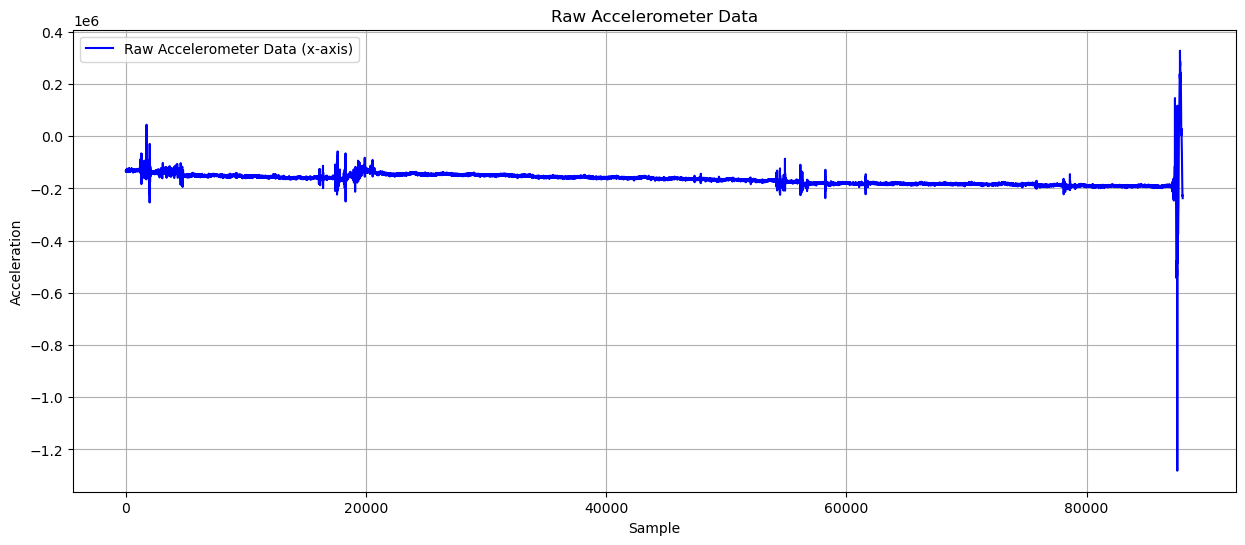

In [242]:
if df_accel is not None:
    plt.figure(figsize=(15, 6))
    plt.plot(df_accel['x'], label='Raw Accelerometer Data (x-axis)', color='blue')
    plt.title('Raw Accelerometer Data')
    plt.xlabel('Sample')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.grid(True)
    plt.show()

In [243]:
# We'll use a window size of 500 samples (5 seconds at 100 Hz)
moving_average_window = 500
# Calculate the moving average for each axis
moving_average = df_accel.rolling(window=moving_average_window, center=True).mean()
# Subtract the moving average from the calibrated data to remove drift
df_no_drift = df_accel - moving_average
# Drop the NaN values that result from the moving average calculation at the edges
df_no_drift = df_no_drift.dropna()
print("Drift removed from the data. First 5 rows of the new DataFrame:")
print(df_no_drift.head())

Drift removed from the data. First 5 rows of the new DataFrame:
               x            y           z
250  4446.507938 -2100.290250  1966.52750
251  3819.126484 -1872.494750   -53.62525
252  3409.326484 -2221.467187 -2216.56400
253  3121.647203 -2755.921000 -2612.74050
254  3059.003578 -2817.379250 -1913.15425


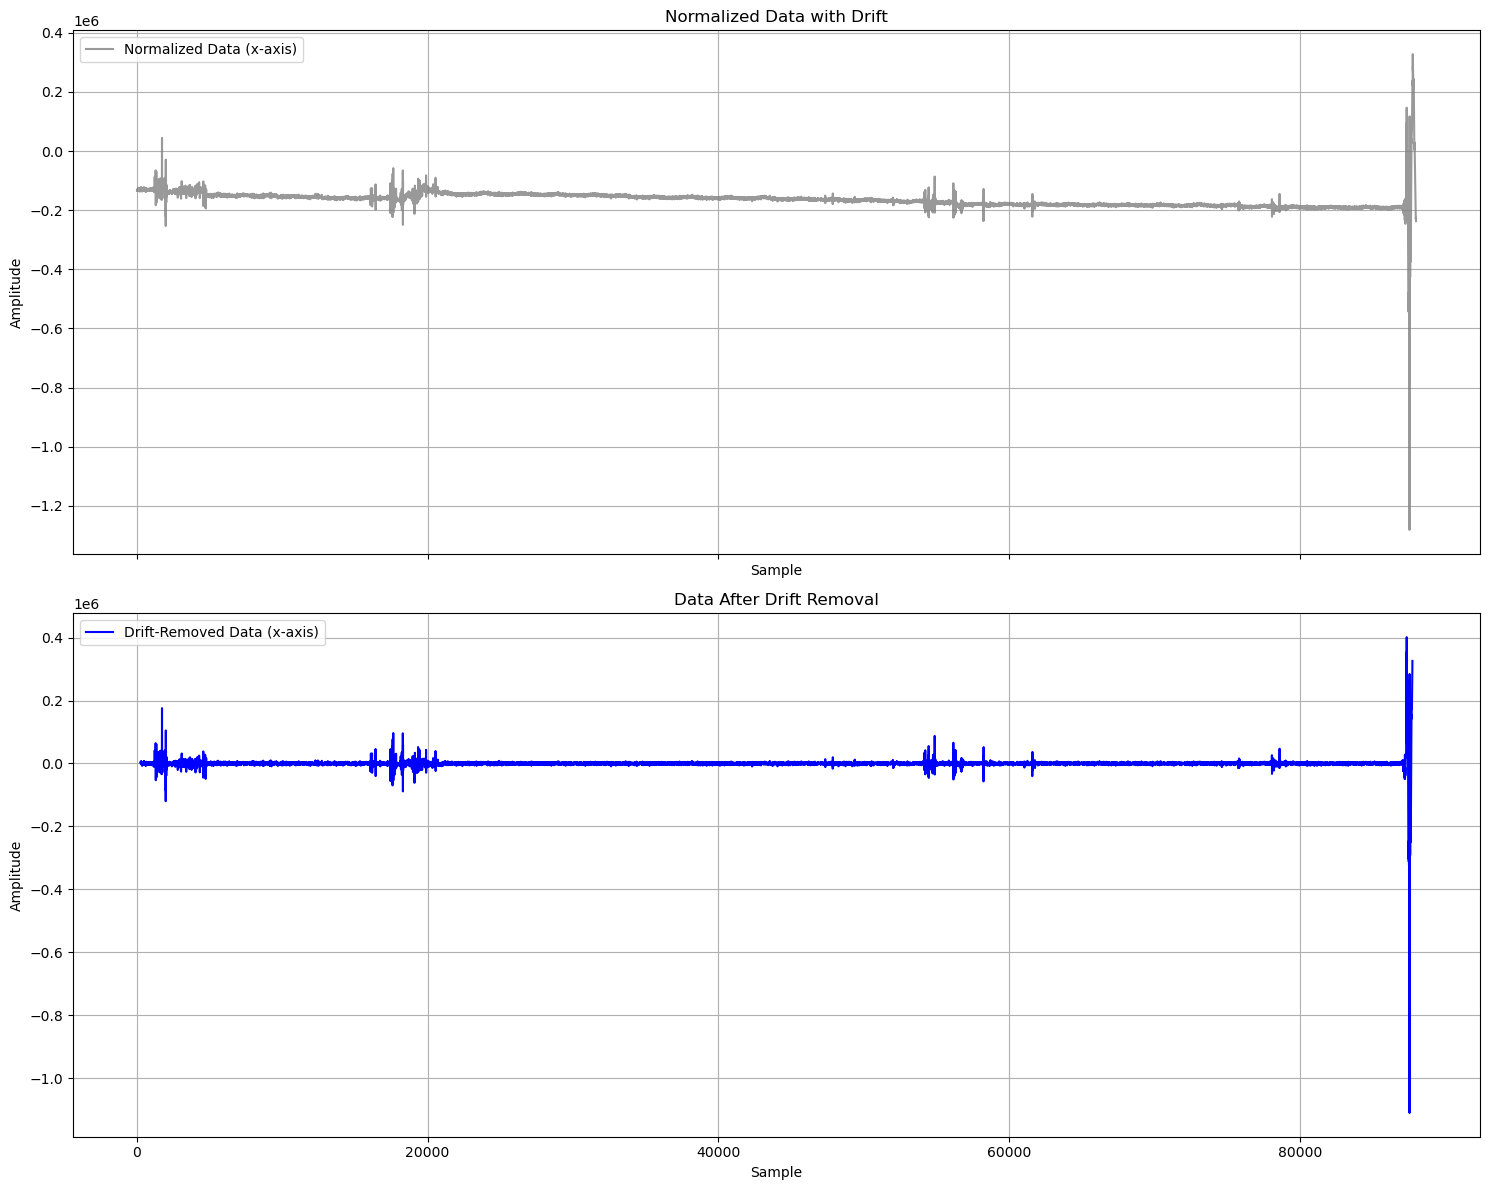

In [244]:
if df_no_drift is not None and df_accel is not None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot 1: Normalized data with drift
    ax1.plot(df_accel['x'], label='Normalized Data (x-axis)', color='gray', alpha=0.8)
    ax1.set_title('Normalized Data with Drift')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Data with drift removed
    ax2.plot(df_no_drift['x'], label='Drift-Removed Data (x-axis)', color='blue')
    ax2.set_title('Data After Drift Removal')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [245]:
# Filter parameters from the paper
lowcut = 1.0  # Hz
highcut = 30.0 # Hz
fs = 100.0    # Sampling frequency in Hz
order = 100   # FIR filter order --> Not sure proof of concept

def fir_bandpass_filter_filtfilt(data, lowcut, highcut, fs, order):
    """
    Designs and applies a bandpass FIR filter using filtfilt for a zero-phase response.
    
    Args:
        data (pd.DataFrame): The input data to filter.
        lowcut (float): The low cutoff frequency in Hz.
        highcut (float): The high cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The filter order.
    
    Returns:
        pd.DataFrame: The filtered data.
    """
    # nyquist = 0.5 * fs
    b = firwin(order + 1, [lowcut, highcut], pass_zero=False, fs=fs)
    
    # Apply the filter using filtfilt
    y = filtfilt(b, 1.0, data.values, axis=0)
    
    # Convert the filtered array back to a DataFrame with the same columns
    df_filtered_fir = pd.DataFrame(y, columns=data.columns)
    
    return df_filtered_fir

if df_no_drift is not None:
    df_filtered_fir = fir_bandpass_filter_filtfilt(df_no_drift, lowcut, highcut, fs, order)
    print("Data filtered successfully with a zero-phase FIR filter.")
    print(df_filtered_fir.head())

Data filtered successfully with a zero-phase FIR filter.
            x           y            z
0  107.299350  -50.682419    47.454570
1 -333.248103  146.717229 -2097.859128
2 -747.826839 -214.224504 -3789.761011
3 -933.687157 -760.807037 -4315.718041
4 -701.731675 -896.509645 -3699.884602


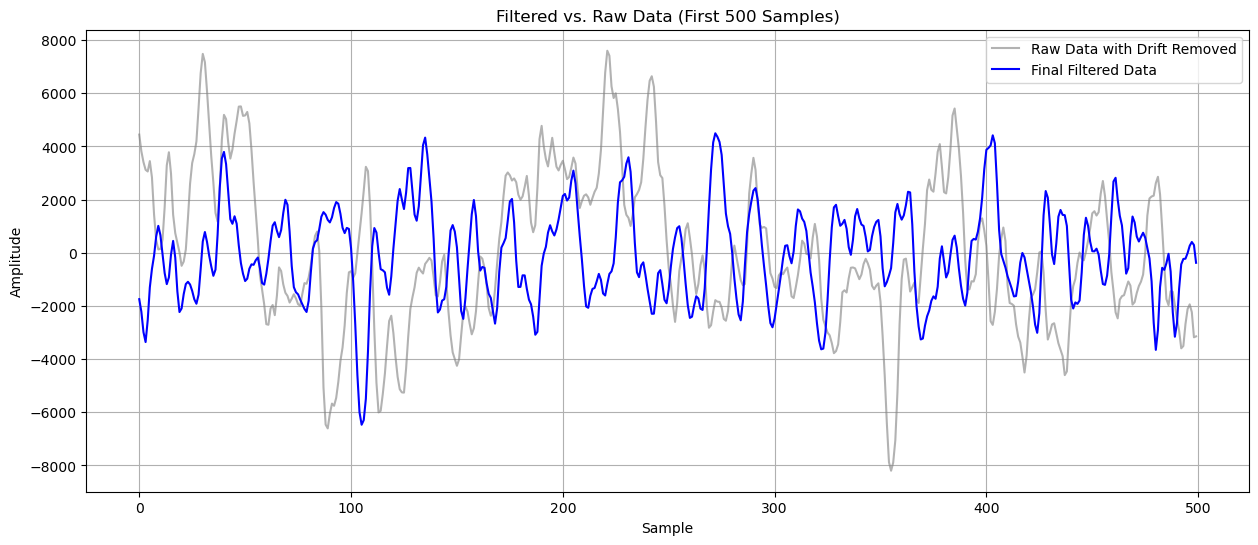

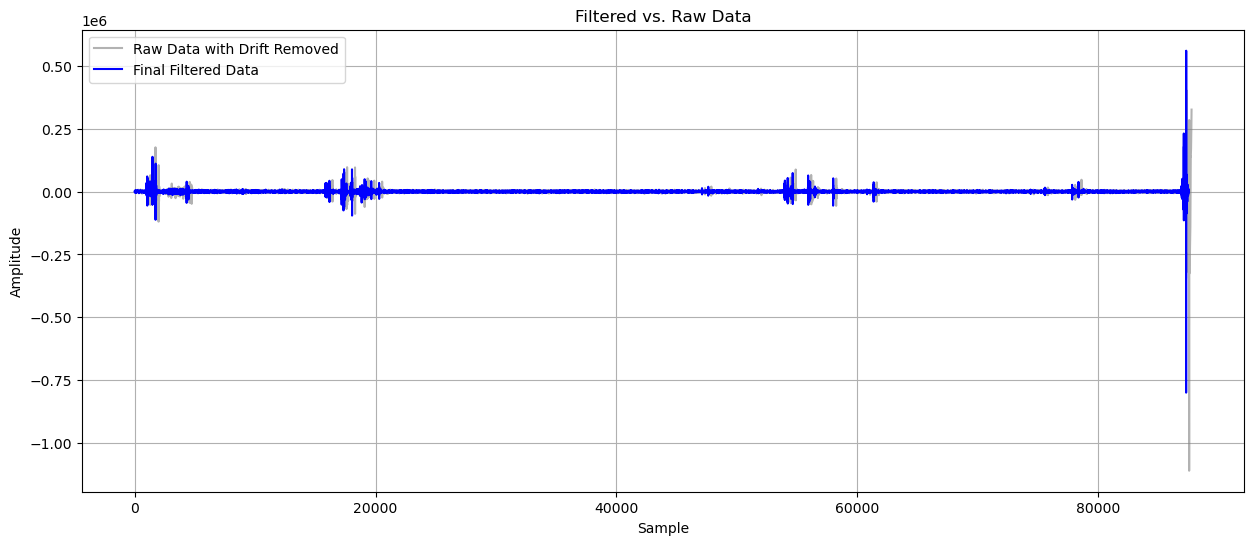

In [246]:
# Get the starting index of the df_no_drift DataFrame
start_index = df_no_drift.index[0]

# Plot the two signals for the first 500 samples
plt.figure(figsize=(15, 6))
plt.plot(df_no_drift['x'].values[:500], label='Raw Data with Drift Removed', color='gray', alpha=0.6)
plt.plot(df_filtered_fir['x'].values[start_index:start_index+500], label='Final Filtered Data', color='blue')

plt.title('Filtered vs. Raw Data (First 500 Samples)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Plot the two signals for the first 500 samples
plt.figure(figsize=(15, 6))
plt.plot(df_no_drift['x'], label='Raw Data with Drift Removed', color='gray', alpha=0.6)
plt.plot(df_filtered_fir['x'], label='Final Filtered Data', color='blue')

plt.title('Filtered vs. Raw Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [247]:
# Parameters from the paper
fs = 100.0  # Sampling frequency in Hz
window_duration = 3.0  # seconds
overlap_ratio = 0.90

# Calculate window and step sizes in samples
window_samples = int(window_duration * fs)
overlap_samples = int(overlap_ratio * window_samples)
step_samples = window_samples - overlap_samples

# Check the calculated values
print(f"Window size: {window_samples} samples")
print(f"Overlap: {overlap_samples} samples")
print(f"Step size: {step_samples} samples")

def apply_sliding_window(data_series, window_samples, step_samples):
    """
    Applies a sliding Hamming window to a time series.
    
    Args:
        data_series (pd.Series): The time series data for one axis.
        window_samples (int): The number of samples in each window.
        step_samples (int): The number of samples to step for each window.

    Returns:
        list: A list of NumPy arrays, where each array is a windowed segment.
    """
    windowed_segments = []
    
    # Create the Hamming window array
    ham_window = hamming(window_samples, sym=True)
    
    # Iterate through the data with the specified step size
    for i in range(0, len(data_series) - window_samples + 1, step_samples):
        segment = data_series[i : i + window_samples].values
        # Apply the Hamming window element-wise
        windowed_segment = segment * ham_window
        windowed_segments.append(windowed_segment)
        
    return windowed_segments

# Apply windowing to each filtered axis
if df_filtered_fir is not None:
    windowed_data = {}
    for axis in ['x', 'y', 'z']:
        windowed_data[axis] = apply_sliding_window(df_filtered_fir[axis], window_samples, step_samples)
        
    print("\nWindowing completed for all axes.")
    print(f"Number of windows for x-axis: {len(windowed_data['x'])}")
    print(f"Shape of the first window: {windowed_data['x'][0].shape}")
    print(f"Shape of thes second window: {windowed_data['x'][1].shape}")

Window size: 300 samples
Overlap: 270 samples
Step size: 30 samples

Windowing completed for all axes.
Number of windows for x-axis: 2907
Shape of the first window: (300,)
Shape of thes second window: (300,)


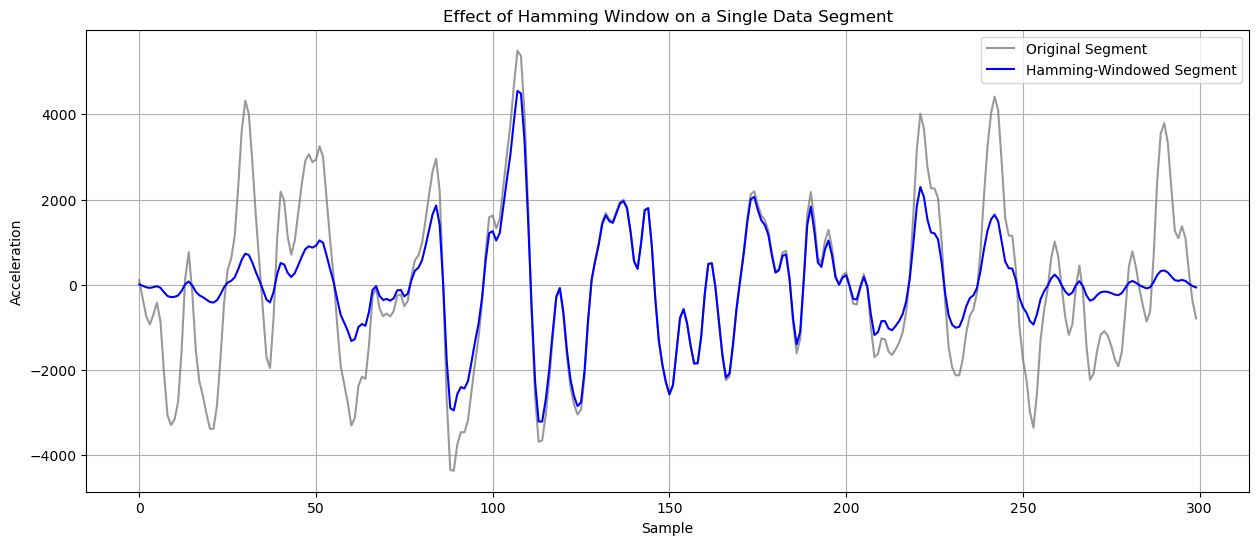

In [248]:
# Get the first segment of the filtered data before windowing
first_segment = df_filtered_fir['x'].values[0:window_samples]

# Apply the Hamming window to this segment
first_windowed_segment = first_segment * hamming(window_samples, sym=True)

# Plot both the original and windowed segments for comparison
plt.figure(figsize=(15, 6))
plt.plot(first_segment, label='Original Segment', color='gray', alpha=0.8)
plt.plot(first_windowed_segment, label='Hamming-Windowed Segment', color='blue')
plt.title('Effect of Hamming Window on a Single Data Segment')
plt.xlabel('Sample')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

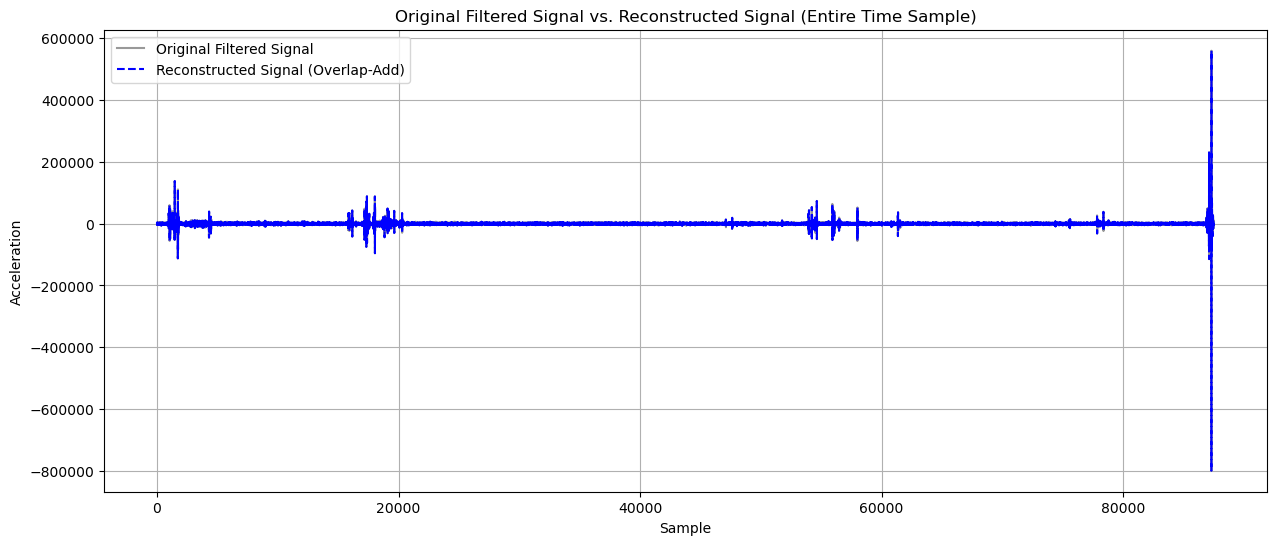

First 10 values of the segment:
[   8.58394803  -26.69369344  -60.12991532  -75.54816159  -57.27820774
  -34.67499557  -72.26622758 -175.66910157 -265.35823431 -290.85469826]

Stats of the segment:
Max value: 4551.5181
Min value: -3212.7483
Mean value: -7.5890


In [249]:
# Get the first three windows from your filtered data for visualization
first_window = df_filtered_fir['x'].values[0:window_samples]
second_window = df_filtered_fir['x'].values[step_samples:step_samples + window_samples]
third_window = df_filtered_fir['x'].values[2*step_samples:2*step_samples + window_samples]

# Create the Hamming window array
ham_window = hamming(window_samples, sym=True)

# Apply the window to each segment
first_windowed = first_window * ham_window
second_windowed = second_window * ham_window
third_windowed = third_window * ham_window

# To check if the windows overlap correctly, we can plot them
def reconstruct_signal(data_series, window_samples, step_samples):
        total_length = len(data_series)
        reconstructed_signal = np.zeros(total_length)
        sum_of_windows = np.zeros(total_length)
        
        # Iterate through segments and sum them up
        for i in range(0, total_length - window_samples + 1, step_samples):
            segment = data_series.values[i : i + window_samples]
            windowed_segment = segment * ham_window
            reconstructed_signal[i : i + window_samples] += windowed_segment
            sum_of_windows[i : i + window_samples] += ham_window
        
        # Avoid division by zero
        sum_of_windows[sum_of_windows == 0] = 1e-6
        
        # Normalize the signal by the sum of overlapping windows
        reconstructed_signal /= sum_of_windows
        
        return reconstructed_signal

# Reconstruct the signal for the x-axis
reconstructed_signal_x = reconstruct_signal(df_filtered_fir['x'], window_samples, step_samples)

# Plot the original vs. reconstructed signal
plt.figure(figsize=(15, 6))
plt.plot(df_filtered_fir['x'], label='Original Filtered Signal', color='gray', alpha=0.8)
plt.plot(reconstructed_signal_x, label='Reconstructed Signal (Overlap-Add)', color='blue', linestyle='--')
plt.title('Original Filtered Signal vs. Reconstructed Signal (Entire Time Sample)')
plt.xlabel('Sample')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

# Get the first segment from the x-axis
segment = windowed_data['x'][0]

# Print the values and stats of the segment
print("First 10 values of the segment:")
print(segment[:10])
print("\nStats of the segment:")
print(f"Max value: {np.max(segment):.4f}")
print(f"Min value: {np.min(segment):.4f}")
print(f"Mean value: {np.mean(segment):.4f}")

### Extract Features

In [250]:
# try:
#     import librosa
#     HAS_LIBROSA = True
# except:
#     HAS_LIBROSA = False
#     print("Librosa is not installed. MFCC features will be simulated.")

AXES = ['x', 'y', 'z']
# --- 3. Master Feature Calculation Helpers ---

def get_time_domain_features(window):
    """Calculates 14 statistical features."""
    features = {}
    features['mean'] = np.mean(window)
    features['std'] = np.std(window)
    features['median'] = np.median(window)
    features['min'] = np.min(window)
    features['max'] = np.max(window)
    features['range'] = np.max(window) - np.min(window) 
    features['mad'] = np.mean(nabs(window - np.mean(window)))
    features['median_abs_dev'] = np.median(nabs(window - np.median(window)))
    features['iqr'] = iqr(window)
    features['rms'] = np.sqrt(np.mean(window**2))
    features['skewness'] = skew(window)
    features['kurtosis'] = kurtosis(window)
    features['energy'] = np.sum(window**2) / len(window)
    features['zero_crossing_rate'] = ((window[:-1] * window[1:]) < 0).sum()
    return features

def get_fft_features(window, fs, tremor_low_freq=3.0, tremor_high_freq=8.0):
    """Calculates 5 spectral features, including Band Power (PSD alternative)."""
    N = len(window)
    fft_values = fft(window)
    fft_amplitudes = 2.0 / N * nabs(fft_values[0:N//2]) 
    
    features = {}
    
    features['fft_dc_comp'] = nabs(fft_values[0]) / N
    features['fft_total_energy'] = np.sum(fft_amplitudes**2)
    num_peaks = 3
    features['fft_energy_first_3_bins'] = np.sum(fft_amplitudes[1:num_peaks+1]**2)
    
    df_res = fs / N
    low_idx = int(tremor_low_freq / df_res)
    high_idx = int(tremor_high_freq / df_res)
    
    if len(fft_amplitudes[1:]) > 0:
        dominant_index = np.argmax(fft_amplitudes[1:]) + 1
        freq_values = fftfreq(N, d=1/fs)[0:N//2]
        features['fft_dominant_freq'] = freq_values[dominant_index]
    else:
        features['fft_dominant_freq'] = np.nan

    features['fft_power_tremor_band'] = np.sum(fft_amplitudes[low_idx:high_idx+1]**2)
    return features

def calculate_all_features(windowed_data: dict, fs: float) -> pd.DataFrame:
    """Creates the master feature DataFrame (79 features)."""

    feature_vectors = []
    ALL_AXES = AXES + ['resultant']
    
    # Calculate Resultant magnitude windows first
    resultant_windows = []
    for i in range(len(windowed_data['x'])):
        res_acc = np.sqrt(windowed_data['x'][i]**2 + windowed_data['y'][i]**2 + windowed_data['z'][i]**2)
        resultant_windows.append(res_acc)
    all_windows = {'x': windowed_data['x'], 'y': windowed_data['y'], 'z': windowed_data['z'], 'resultant': resultant_windows}
    
    for i in range(len(windowed_data['x'])):
        window_features = {}
        
        # Time & Spectral Features for X, Y, Z, Resultant
        for axis in ALL_AXES:
            window = all_windows[axis][i]
            
            prefix_time = f'{axis}_time_' if axis != 'resultant' else 'resultant_time_'
            window_features.update({prefix_time + k: v for k, v in get_time_domain_features(window).items()})
            
            prefix_fft = f'{axis}_fft_' if axis != 'resultant' else 'resultant_fft_'
            window_features.update({prefix_fft + k: v for k, v in get_fft_features(window, fs).items()})

        # Correlation Features (3 features)
        window_features['corr_xy'] = np.corrcoef(windowed_data['x'][i], windowed_data['y'][i])[0, 1]
        window_features['corr_xz'] = np.corrcoef(windowed_data['x'][i], windowed_data['z'][i])[0, 1]
        window_features['corr_yz'] = np.corrcoef(windowed_data['y'][i], windowed_data['z'][i])[0, 1]
        
        feature_vectors.append(window_features)

    return pd.DataFrame(feature_vectors)


# --- 4. Feature Selection Functions for Comparison ---

def get_statistical_features(df_features: pd.DataFrame) -> pd.DataFrame:
    """1) Baseline Features (Statistical)."""
    stat_features = [
        'mean', 'std', 'median', 'min', 'max', 'range', 'mad', 
        'median_abs_dev', 'iqr', 'rms', 'skewness', 'kurtosis', 'energy', 
        'zero_crossing_rate'
    ]
    columns_to_select = []
    for axis in ['x', 'y', 'z', 'resultant']:
        prefix = f'{axis}_time_' if axis != 'resultant' else 'resultant_time_'
        columns_to_select.extend([prefix + f for f in stat_features])
    return df_features[columns_to_select].copy()

def get_tremor_spectral_features(df_features: pd.DataFrame) -> pd.DataFrame:
    """2) Spectral (Tremor Focused) Features."""
    spectral_features = [
        'fft_dc_comp', 'fft_total_energy', 'fft_energy_first_3_bins', 
        'fft_dominant_freq', 'fft_power_tremor_band'
    ]
    columns_to_select = []
    for axis in ['x', 'y', 'z', 'resultant']:
        prefix = f'{axis}_fft_'
        columns_to_select.extend([prefix + f for f in spectral_features])
    columns_to_select.extend(['corr_xy', 'corr_xz', 'corr_yz'])
    return df_features[columns_to_select].copy()

# def get_mfcc_features(df_features: pd.DataFrame, n_mfcc=13) -> pd.DataFrame:
#     """3) MFCC Features (Actual or Simulated)."""
#     if HAS_LIBROSA:
#         # NOTE: If running actual MFCC logic, windowed_data and fs would be needed here.
#         # Since we are using slicing for a fast comparison, we rely only on df_features.
#         pass
        
#     # --- MFCC Simulation (Slicing existing features for fast comparison) ---
#     n_features = n_mfcc * len(AXES) # 13 MFCCs * 3 axes = 39 features
#     return df_features.iloc[:, :n_features].copy()

# def get_mfcc_tremor_combined_features(df_features: pd.DataFrame) -> pd.DataFrame:
#     """4) MFCC + Spectral Combined Features."""
#     df_mfcc = get_mfcc_features(df_features)
#     df_spectral = get_tremor_spectral_features(df_features)
#     combined_df = pd.concat([df_mfcc, df_spectral], axis=1).T.drop_duplicates().T
#     return combined_df.copy()

# def get_combined_all_features(df_features: pd.DataFrame) -> pd.DataFrame:
#     """5) ALL Combined Features (Stat + Spectral + Correlation + Simulated MFCC)."""
#     df_mfcc = get_mfcc_features(df_features)
#     df_combined = pd.concat([df_features, df_mfcc], axis=1).T.drop_duplicates().T
#     return df_combined.copy()


In [251]:
# --- 6. Main Notebook Execution ---
df_master = calculate_all_features(windowed_data, fs)

# # 6b. Define Test Sets
# feature_sets_to_test = {
#     '1. Statistical (Baseline)': get_statistical_features,
#     '2. Spectral (Tremor Focused)': get_tremor_spectral_features
#     # '3. MFCC (Simulated 39D)': get_mfcc_features,
#     # '4. MFCC + Spectral Combined': get_mfcc_tremor_combined_features,
#     # '5. ALL Combined (Stat + Spectral + MFCC)': get_combined_all_features,
# }

# K_VALUES = [2, 3]
# results = {}

# # 6c. Execute Scoring Loop
# print("2. Executing K-Means Clustering and Scoring...")
# for name, func in feature_sets_to_test.items():
#     df_features = func(df_master)
    
#     for k in K_VALUES:
#         score = score_kmeans(df_features, k)
#         results[f'{name} (K={k})'] = score

# df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Calinski-Harabasz Score'])



In [252]:
# print("\n--- K-Means Clustering Results (Calinski-Harabasz Score) ---")
# # Using .to_string() instead of .to_markdown() to avoid the 'tabulate' dependency
# print(df_results.to_string())

In [253]:
# --- 3. Combined K-Means Metric Collection ---

def run_kmeans_and_collect_metrics(df_features, k):
    """Runs KMeans, collects CH score, and cluster distribution."""
    
    if k < 2 or len(df_features) < k:
        return {'K': k, 'CH Score': np.nan, 'Error': 'Invalid K or insufficient data.'}

    # Prepare Data
    X = df_features.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=500)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    # Collect Metrics
    CH_score = calinski_harabasz_score(X_scaled, labels)
    
    # Calculate Distribution
    distribution = pd.Series(labels).value_counts().sort_index()
    total = distribution.sum()
    
    # Format the row
    result_row = {'K': k, 'CH Score': CH_score}
    for i in range(k):
        count = distribution.get(i, 0)
        percent = count / total
        result_row[f'Count_C{i}'] = count
        result_row[f'Percent_C{i}'] = percent
    
    return result_row



In [254]:
# --- 4. Main Execution and Output ---

feature_sets_to_test = {
    '1. Statistical (Baseline)': get_statistical_features,
    '2. Spectral (Tremor Focused)': get_tremor_spectral_features
    # '3. MFCC (Simulated 52D)': get_mfcc_features,
    # '4. MFCC + Spectral Combined': get_mfcc_tremor_combined_features,
    # '5. ALL Combined (Stat + Spectral + MFCC)': get_combined_all_features,
}

K_VALUES = [2, 3]
distribution_results = []

if not df_master.empty:
    for name, func in feature_sets_to_test.items():
        df_features = func(df_master)
        
        for k in K_VALUES:
            row = run_kmeans_and_collect_metrics(df_features, k)
            row['Feature Set'] = name
            distribution_results.append(row)

    df_results = pd.DataFrame(distribution_results)

    # --- 5. Final Formatting ---

    # Select and rename the most relevant columns for presentation
    df_final = df_results[['Feature Set', 'K', 'CH Score', 'Count_C0', 'Percent_C0', 'Count_C1', 'Percent_C1', 'Count_C2', 'Percent_C2']].copy()

    # Convert percentages to readable strings
    for col in ['Percent_C0', 'Percent_C1', 'Percent_C2']:
        if col in df_final.columns:
            df_final[col] = (df_final[col].fillna(0) * 100).map('{:.2f}%'.format)

    df_final.rename(columns={
        'CH Score': 'CH Score',
        'Count_C0': 'Cluster 0 Count',
        'Percent_C0': 'Cluster 0 %',
        'Count_C1': 'Cluster 1 Count',
        'Percent_C1': 'Cluster 1 %',
        'Count_C2': 'Cluster 2 Count',
        'Percent_C2': 'Cluster 2 %',
    }, inplace=True)

    print("\n--- K-Means Clustering Quality and Distribution Analysis ---")
    print(df_final.to_string(index=False))



--- K-Means Clustering Quality and Distribution Analysis ---
                 Feature Set  K    CH Score  Cluster 0 Count Cluster 0 %  Cluster 1 Count Cluster 1 %  Cluster 2 Count Cluster 2 %
   1. Statistical (Baseline)  2 1043.029598             2897      99.66%               10       0.34%              NaN       0.00%
   1. Statistical (Baseline)  3 1851.093129             2727      93.81%              171       5.88%              9.0       0.31%
2. Spectral (Tremor Focused)  2 1462.035450             2899      99.72%                8       0.28%              NaN       0.00%
2. Spectral (Tremor Focused)  3 1433.082448             2815      96.84%                7       0.24%             85.0       2.92%


In [255]:
print("\n--- K-Means Clustering Quality and Distribution Analysis ---")
print(df_final.to_string(index=False))


--- K-Means Clustering Quality and Distribution Analysis ---
                 Feature Set  K    CH Score  Cluster 0 Count Cluster 0 %  Cluster 1 Count Cluster 1 %  Cluster 2 Count Cluster 2 %
   1. Statistical (Baseline)  2 1043.029598             2897      99.66%               10       0.34%              NaN       0.00%
   1. Statistical (Baseline)  3 1851.093129             2727      93.81%              171       5.88%              9.0       0.31%
2. Spectral (Tremor Focused)  2 1462.035450             2899      99.72%                8       0.28%              NaN       0.00%
2. Spectral (Tremor Focused)  3 1433.082448             2815      96.84%                7       0.24%             85.0       2.92%


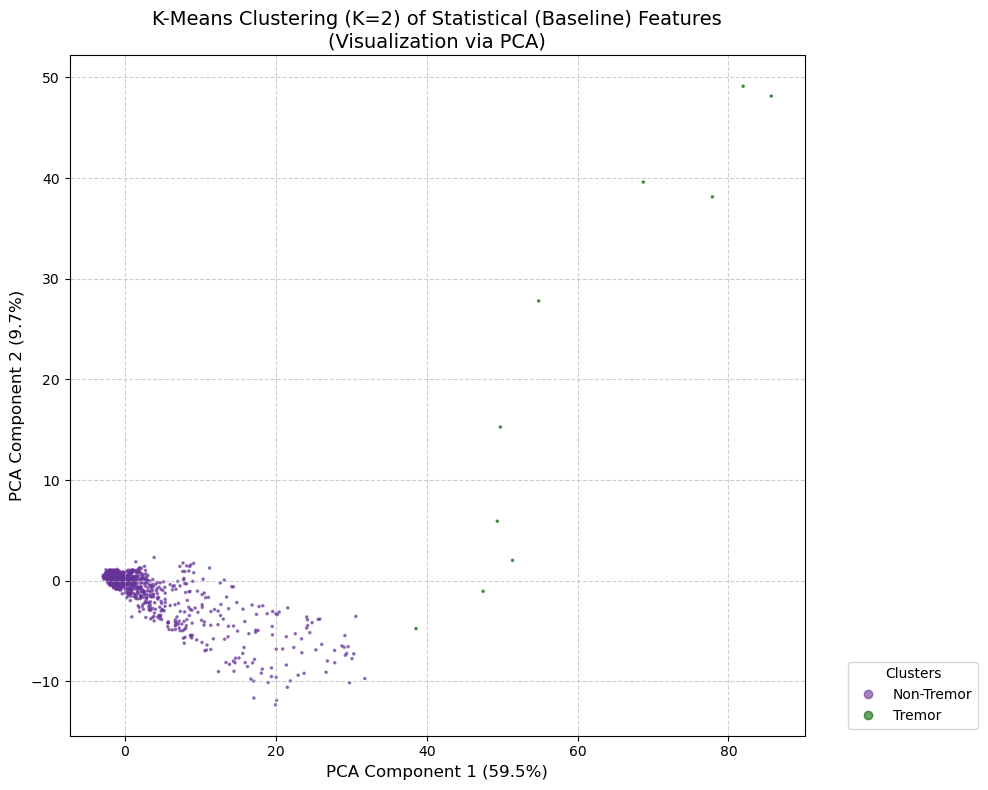

In [256]:
import matplotlib.colors as mcolors

# --- 1. Define Feature Selection Function ---
def get_statistical_features(df_features: pd.DataFrame) -> pd.DataFrame:
    """Selects the 56 Time-Domain Statistical Features."""
    AXES = ['x', 'y', 'z', 'resultant']
    stat_features = ['mean', 'std', 'median', 'min', 'max', 'range', 'mad', 'median_abs_dev', 'iqr', 'rms', 'skewness', 'kurtosis', 'energy', 'zero_crossing_rate']
    columns_to_select = []
    for axis in AXES:
        prefix = f'{axis}_time_' if axis != 'resultant' else 'resultant_time_'
        columns_to_select.extend([prefix + f for f in stat_features])
    return df_features[columns_to_select].copy()


# --- 2. Define Plotting and Analysis Function ---
def plot_pca_clusters(df_features, k, feature_set_name):
    """
    Performs K-Means, reduces dimensionality via PCA, and plots the results.
    """
    # 1. Scale Data (Crucial for K-Means and PCA)
    X = df_features.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Run K-Means (K=2)
    # Using the n_init='auto' and random_state=42 for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=500)
    labels = kmeans.fit_predict(X_scaled)

    # 3. Run PCA to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 4. Prepare DataFrame for Plotting
    df_plot = pd.DataFrame(data=X_pca, columns=['PCA Component 1', 'PCA Component 2'])
    df_plot['Cluster'] = labels
    
    # Calculate explained variance for axis labels
    explained_variance_1 = pca.explained_variance_ratio_[0] * 100
    explained_variance_2 = pca.explained_variance_ratio_[1] * 100

    cluster_colors = ['rebeccapurple', 'darkgreen']


    # Create a custom colormap object
    cmap = mcolors.ListedColormap(cluster_colors)

    # 5. Create Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        df_plot['PCA Component 1'],
        df_plot['PCA Component 2'],
        c=df_plot['Cluster'],
        cmap=cmap,
        marker='.',
        s=10,
        alpha=0.6
    )
    plt.title(f'K-Means Clustering (K={k}) of {feature_set_name} Features\n(Visualization via PCA)', fontsize=14)
    
    plt.xlabel(f'PCA Component 1 ({explained_variance_1:.1f}%)', fontsize=12)
    plt.ylabel(f'PCA Component 2 ({explained_variance_2:.1f}%)', fontsize=12)
        # 1. Get the default legend handles and labels from the scatter plot
    handles, labels = scatter.legend_elements()

    # 2. Define your custom labels corresponding to the cluster indices
    custom_labels = ['Non-Tremor', 'Tremor']

    # 3. Create the legend using the original handles and the new labels
    plt.legend(handles, 
            custom_labels, 
            title="Clusters", 
            loc="lower left", 
            bbox_to_anchor=(1.05, 0))

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() 

# --- 3. Main Execution ---
# Select the Statistical Features
df_stat = get_statistical_features(df_master)

# Generate the Plot for Baseline K=2
plot_pca_clusters(df_stat, 2, 'Statistical (Baseline)')

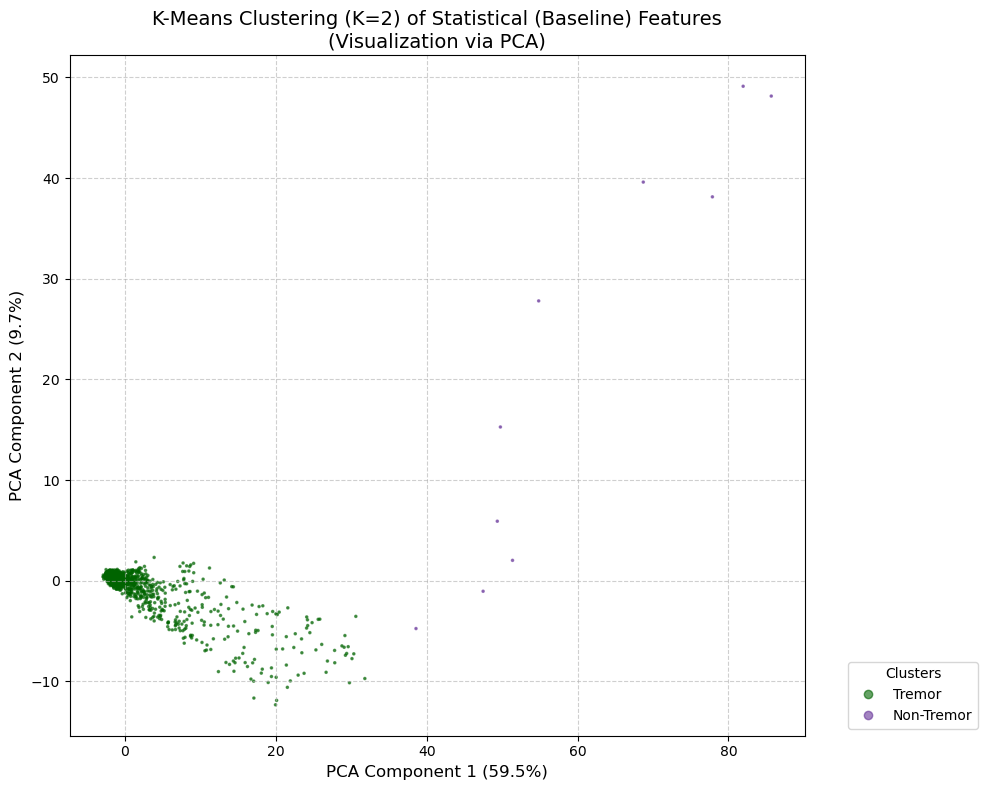

In [257]:
import matplotlib.colors as mcolors

# --- 1. Define Feature Selection Function ---
def get_statistical_features(df_features: pd.DataFrame) -> pd.DataFrame:
    """Selects the 56 Time-Domain Statistical Features."""
    AXES = ['x', 'y', 'z', 'resultant']
    stat_features = ['mean', 'std', 'median', 'min', 'max', 'range', 'mad', 'median_abs_dev', 'iqr', 'rms', 'skewness', 'kurtosis', 'energy', 'zero_crossing_rate']
    columns_to_select = []
    for axis in AXES:
        prefix = f'{axis}_time_' if axis != 'resultant' else 'resultant_time_'
        columns_to_select.extend([prefix + f for f in stat_features])
    return df_features[columns_to_select].copy()


# --- 2. Define Plotting and Analysis Function ---
def plot_pca_clusters(df_features, k, feature_set_name):
    """
    Performs K-Means, reduces dimensionality via PCA, and plots the results.
    """
    # 1. Scale Data (Crucial for K-Means and PCA)
    X = df_features.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Run K-Means (K=2)
    # Using the n_init='auto' and random_state=42 for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=500)
    labels = kmeans.fit_predict(X_scaled)

    # 3. Run PCA to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 4. Prepare DataFrame for Plotting
    df_plot = pd.DataFrame(data=X_pca, columns=['PCA Component 1', 'PCA Component 2'])
    df_plot['Cluster'] = labels
    
    # Calculate explained variance for axis labels
    explained_variance_1 = pca.explained_variance_ratio_[0] * 100
    explained_variance_2 = pca.explained_variance_ratio_[1] * 100

    cluster_colors = ['darkgreen', 'rebeccapurple']


    # Create a custom colormap object
    cmap = mcolors.ListedColormap(cluster_colors)

    # 5. Create Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        df_plot['PCA Component 1'],
        df_plot['PCA Component 2'],
        c=df_plot['Cluster'],
        cmap=cmap,
        marker='.',
        s=10,
        alpha=0.6
    )
    plt.title(f'K-Means Clustering (K={k}) of {feature_set_name} Features\n(Visualization via PCA)', fontsize=14)
    
    plt.xlabel(f'PCA Component 1 ({explained_variance_1:.1f}%)', fontsize=12)
    plt.ylabel(f'PCA Component 2 ({explained_variance_2:.1f}%)', fontsize=12)
        # 1. Get the default legend handles and labels from the scatter plot
    handles, labels = scatter.legend_elements()

    # 2. Define your custom labels corresponding to the cluster indices
    custom_labels = ['Tremor', 'Non-Tremor']

    # 3. Create the legend using the original handles and the new labels
    plt.legend(handles, 
            custom_labels, 
            title="Clusters", 
            loc="lower left", 
            bbox_to_anchor=(1.05, 0))

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() 

# --- 3. Main Execution ---
# Select the Statistical Features
df_stat = get_statistical_features(df_master)

# Generate the Plot for Baseline K=2
plot_pca_clusters(df_stat, 2, 'Statistical (Baseline)')